<a href="https://colab.research.google.com/github/skywalker290/Image-Classification-Model/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐕 End-to-End Multil-class Dog Class bread classification

This notebook builds an end-to-end muti-class image classfier using tensorflow 2.0 and Tensorflow hub

## 1. Problem

Identifying  the breed of a dog given an image of the dog.

## 2. Data

The data we are using is from kaggle dog breed identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilties for each dog breed of each test image.
https://www.kaggle.com/c/dog-breed-identification/data

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/ Transfer Learning.
* There are 120 Breads of dogs(120 diffrent class). with labels
* There are around 10000+ Images in Training and testing set. no labels






### Initial Credentials Setup

In [1]:
# Initial Credetials Setup
!mkdir /root/.kaggle
!echo "{"username":"skywalker290","key":"f98d8b5f743369ea5729ca5703404104"}" > /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.jsonk

import os

os.environ['KAGGLE_USERNAME'] = 'skywalker290'
os.environ['KAGGLE_KEY'] = 'f98d8b5f743369ea5729ca5703404104'



mkdir: cannot create directory ‘/root/.kaggle’: Permission denied


/bin/bash: /root/.kaggle/kaggle.json: Permission denied
cat: /root/.kaggle/kaggle.json: Permission denied
chmod: cannot access '/root/.kaggle/kaggle.jsonk': Permission denied


In [2]:
# Downloading data
# !kaggle competitions download -c dog-breed-identification
# !mkdir data
# !unzip dog-breed-identification.zip -d data/
# !mkdir logs


### Getting Workspace Ready

* Import Tensorflow 2.x
* Import Tensorflow Hub
* Make sure we're using GPU



In [3]:
# Import Tensorflow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("Tensflow version:",tf.__version__)
print("Tensflow_hub version:",hub.__version__)

# Check for GPU availability
print("GPU","available (YESSS!!!!!!!!!!)" if tf.config.list_physical_devices("GPU") else "Not avaialble :(")

2024-04-12 21:30:03.520803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 21:30:03.826700: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 21:30:05.910369: W tensorflow/c/logging.cc:37] Could not load dynamic library 'libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so'; dlerror: libd3d12.so: cannot open shared object file: No such file or directory
2024-04-12 21:30:05.910393: W tensorflow/c/logging.cc:37] Could not load DirectML.
2024-04-12 21:30:05.910397: I ten

Tensflow version: 2.10.0
Tensflow_hub version: 0.15.0
GPU Not avaialble :(


## Getting Our data ready(Turning into tensors)

with all the  machine learning  models, our data  has to be in numerical format. So that's what we'll be doing first. Turning our images  into tensors
(numerical representations).

In [4]:
# check out the labels of our data
import pandas as pd
labels_csv = pd.read_csv("data/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

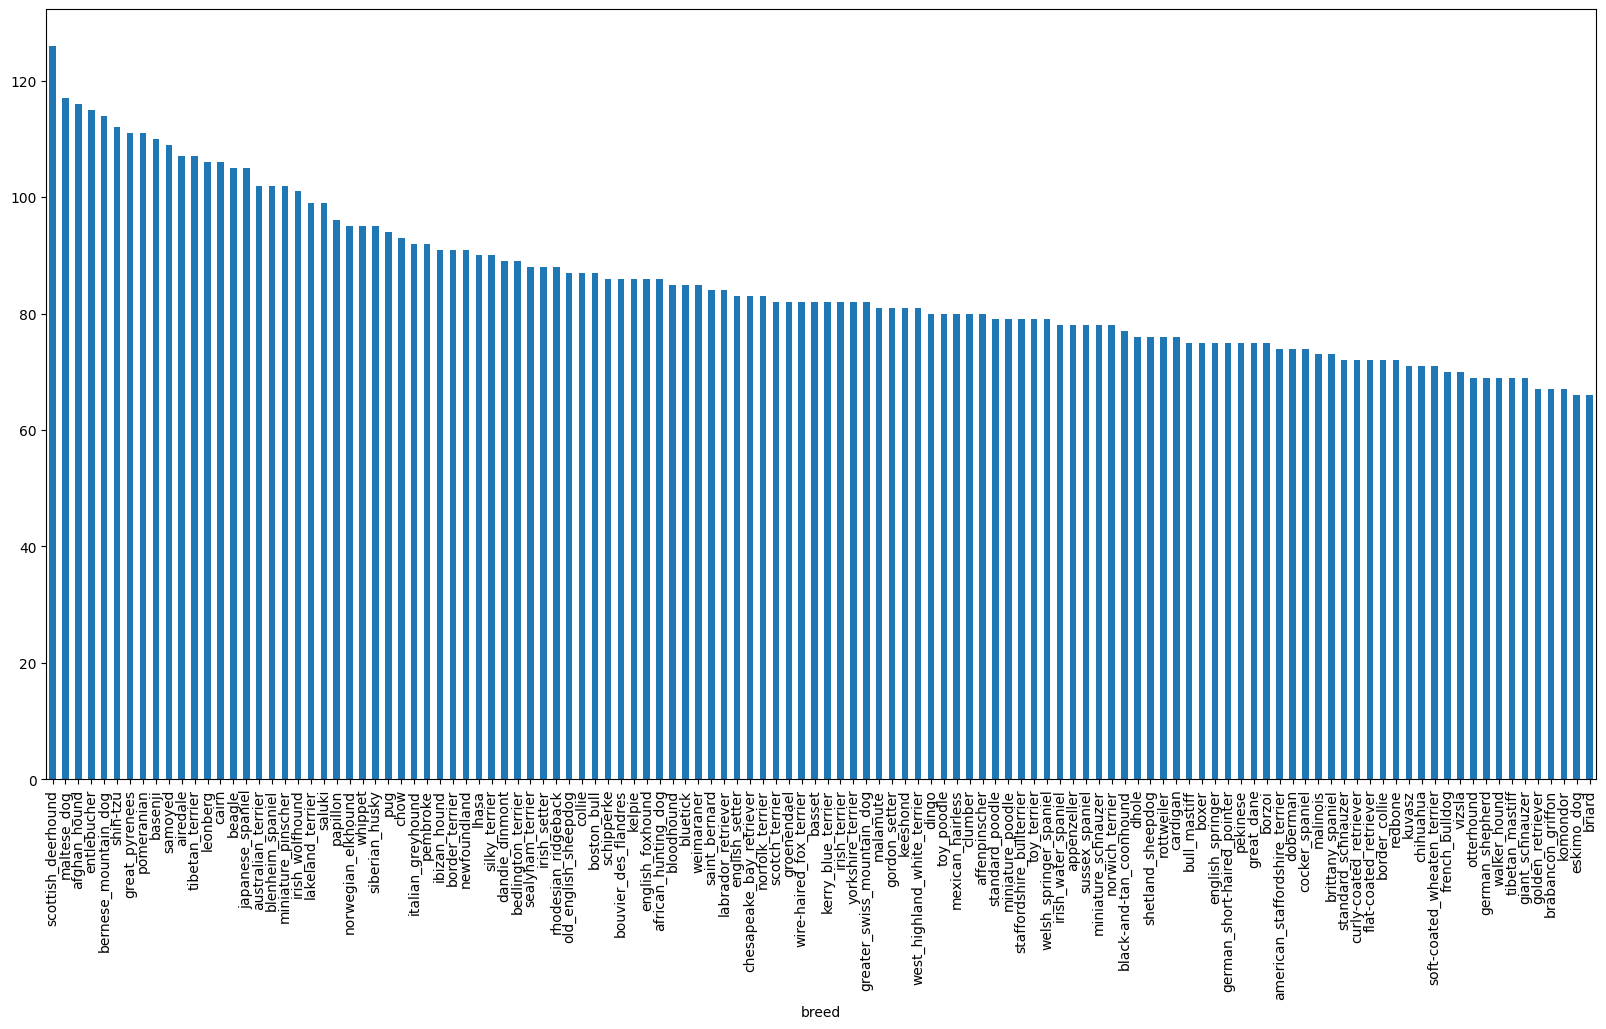

In [5]:
# lets see how many diffrent images do we have for a breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [6]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

In [7]:
!pip install IPython

Defaulting to user installation because normal site-packages is not writeable


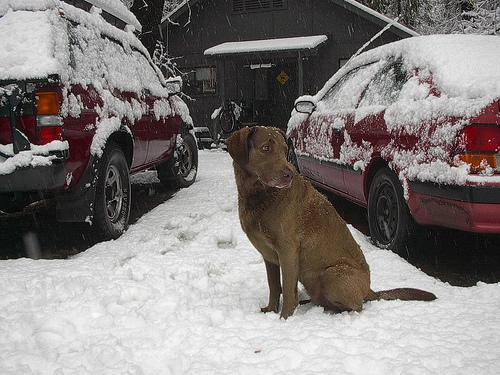

In [8]:
 # lets view an image
 from IPython.display import Image
 Image("data/train/fff43b07992508bc822f33d8ffd902ae.jpg")

### Getting images and their labels

lets get a list of all of our image file pathnames

In [9]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [10]:
# create pathnames from image ID's
filenames = [ "data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# check the first 10
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# check whether number of filenames matches number of actual image files
import os
if len(os.listdir("data/train/"))==len(filenames):
  print("Filenames match actal amount of files!!! Proceed.")
else :
  print(("Filenames do not match"))

Filenames match actal amount of files!!! Proceed.


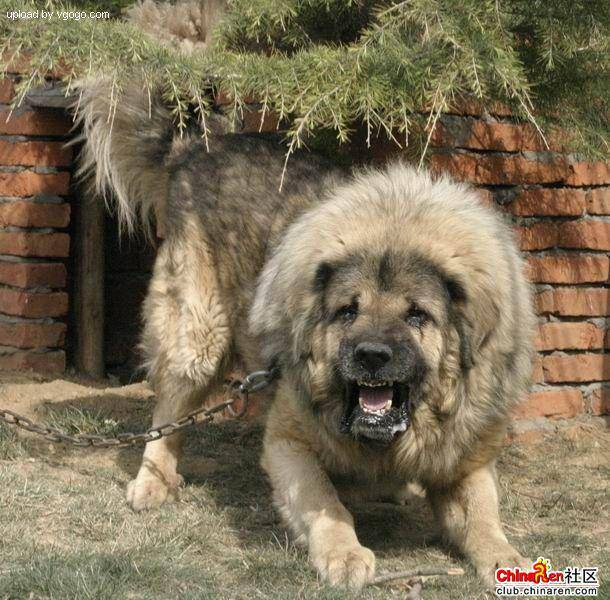

In [12]:
# One more check
Image(filenames[9000])

In [13]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, lets prepare our labels.

In [14]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
 # see if number of labels matches the number of filenames

if len(labels)== len(filenames):
  print("Match")
else :
  print("Do not match")

Match


In [17]:
# find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [18]:
len(unique_breeds)# we have 120 breeds of dogs both in data set and here

120

In [19]:
# turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds


boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# turn every label inot boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
boolean_labels[0].astype(int) # To print all the data in form of zeros and ones

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Creating our own validation set
since the dataset from kaggle doesnt come with validation set so we are gonna create one of our own.
😎

In [22]:
# setup X and Y variables;
X = filenames
y = boolean_labels

In [23]:
len(filenames)

10222

We are gonna work on 10K+ Images so we aint gonna work on the whole we will take 1K first and then go with the whole bunch later.

Now this is some cool shit.
:)

In [24]:
# Set Number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000,max:10222,step:1000}

In [25]:
# lets split of the data for train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],random_state=42,test_size=0.2)

# check the shape of data
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [26]:
X_train[:5],(y_train[:5])

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocessing Images(Turning Images into Tensors)
To preprocess images we gonna write a function which does few things:
1. Take a image filepath as input
2. Make tensorflow read the 'image' and save it into a variable
3. Turn our Jpg images into tensors.
4. Resize the image to a standard size (224,224)
5. return the modified image


Before we do, lets see what importing and image looks like.

In [27]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [28]:
image.max(), image.min()

(255, 0)

In [29]:
# lets turn this into a tensor
# we can convert almost anything into a tensor using this
# Benifit: it can run on GPU so gpu can find patterns in this lot faster than our cpu
tf.constant(image)

2024-04-12 21:30:10.719210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensor, lets make a function to preprocess them.
1. Take a image filepath as input
2. Make tensorflow read the 'image' and save it into a variable
3. Turn our Jpg images into tensors.
4. Normalise our image convert colour channel values 0-255 to 0-1
5. Resize the image to a standard size (224,224)
6. return the modified image


In [30]:
# Define Image size
IMG_SIZE=224

# create a function for preprocesssing images
def process_image(image_path,img_size=IMG_SIZE):
  """
  Takes image path and turns image into tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # turn jpg image into numerical tensor with 3 colour channels(red,green,blue)
  image = tf.image.decode_jpeg(image,channels=3)
  # convert RGB values 0-255 to values 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image to desired size (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

  return image


Tensorflow likes the data in form of batches.
what is batches now?it is also called a mini batch a small portion of your data
Yann LeCun Batch Size = 32,
jeremy howard.

---


**Yenn Lecun, Jeremy Howard are one of the best ML and AI experts**

## Turning our data into batches

why turn our data into batches?
lets say you're trying to process 10000+ images in one go... they all might not fit into memory.

->so thats why we do about 32 images at a time(batch size can be manually adjusted if needed be).

->In order to use tensorflow effectively we need our data in form of tensorflow tuples which look like this:
`(image ,label)`.



In [31]:
# create a simple functon to return a tuple
def get_image_label(image_path,label):
  """
  Take image path and label and the associated labels, processs the image and returns the tuple of image,label
  """
  image = process_image(image_path)
  return image,label

In [32]:
# Demo of the above
get_image_label(X[42],y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn our data into tuples of tensors in the form: `(image,label)`, lets make function to turn all of our data (X & Y) into batches.

In [33]:
# define a batch size
BATCH_SIZE = 32

# lets create a fucntion to create batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of images X and labels Y pairs,
  shuffles the data if its a training data
  doesn't shuffle if its validation data
  Also accept test data as input(No labels).
  """

  # if the data is test dataset we probably dont have labels
  if test_data:
      print("Creating Test data Batches....")
      data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths (no labels)
      data_batch = data.map(process_image).batch(BATCH_SIZE)# this maps the dataslices with process image function and create batches
      return data_batch


  # if data is a validation data
  elif valid_data:
    print("Creating Validation Data Batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),# Filepaths
                                               tf.constant(y)))# Labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch



  else:
    print("Creating Training Data Batches....")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(x), #Filepaths
                                             tf.constant(y)))  # Labels
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # create (image,label) tuples (this also turn the image path into a preprocessed image)
    data_batch = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch




In [34]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [35]:
# Create training and validation data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val, valid_data=True)


Creating training data batches...
Creating validation data batches...


In [36]:
# lets check out the diffrent attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualising Data Batches

Our data is now in batches, However it can a little hard to understand them so we are gonna visualise the data

In [37]:
import matplotlib.pyplot as plt

# Create a funciton for viewing images in a data batch
def show_25_images(images,labels):
    """
    display a plot of 25 images and their labels from a data batch.
    """

    # setup the figure
    plt.figure(figsize=(10,10))
    # loop through 25 images
    for i in range(25):
        # Create subplots (5 rows X Columns)
        ax = plt.subplot(5,5,i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title 
        plt.title(unique_breeds[labels[i].argmax()])
        #Turn the grid lines off
        plt.axis("off")

In [38]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

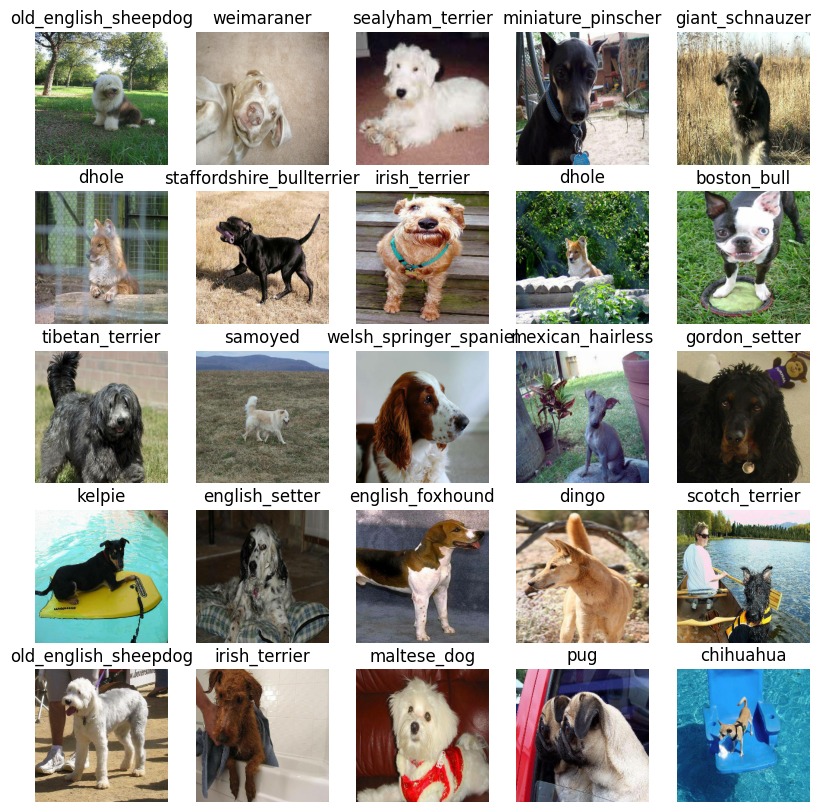

In [39]:
# Now lets visualise the data in a training batch

train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

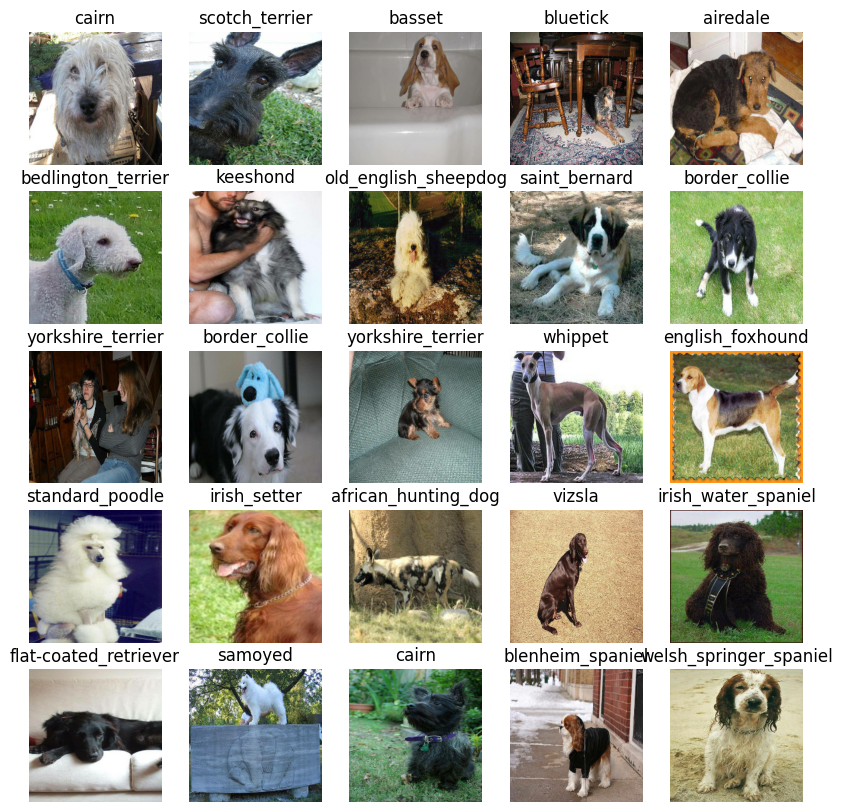

In [40]:
# Now lets visualise a Validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels);

## Building The Model(using Transfered Learning)

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of tensors) to our model.
* Theo output shape (image labels, in the form of tensors) of our model.
* The URL of the model we want to use from Tensorflow Hub.

https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

Some of the other libraries for Transfered Learning are :

->Pytorch Hub

->Model zoo

->Papers with Code(Recent Deep learning Research)


In [41]:
# Setup Input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Batch, height , width ,colour channels

# Setup output Shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup Model URL form Tensorflow Hub
MODEL_URL= "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our input, outputs and model ready to go. Lets's put them otgether into a keras deep learning model!

lets create a fucntion which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a keras model in sequential fashion(fo this first , then this , then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model(telling what input shape it will be getting).
* returns the Model.

All of theese steps can be found here: https://www.tensorflow.org/guide/keras/overview

Here the ouput of the pre-build model is varible while the input parameters are fixed.

In [42]:
# create a function which builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building Model with:", MODEL_URL)

    # setup the model Layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # layer 2 (output layer)
    ])

    # compiler the model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [43]:
model = create_model()
model.summary()     

Building Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Call backs are helper fucntion a mode can use druing training to do such thins as save it s progress, check its prgress or stop traiining early if a model stops imporving.

we'll create two callbacks, one for tensorboard which helps track out models progress and another for early stoping whcih prevents our model from training for too long.

### TensorBoard Callback
To setup a  tesnsor board callback , we need to do 3 things:
1. Load teh tensorBoard ntoebook extension 
2. Create a TessorBoard Callback which is able to save logs to directory and pass it to our model's  fit() function.
3. visualize our models training lgos which the `%tensorboard` magic function.

In [44]:
 ## Load TensforBoard notebook extension

%load_ext tensorboard

In [45]:
import datetime

# Create a fucntion to build a tensorBoard Callback
def create_tensorboard_callback():
    # create a log directory
    logdir = os.path.join('logs',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))  # so the logs get racked whenever we run an experiment
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping callback
stop training when a quantity stops improving

In [46]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",patience = 3 )
# stop training the model if it doesn't improve for 3 epocs

## Training a model(on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [47]:
NUM_EPOCHS = 100 #@param{type: "slider",min:10,max:100}

In [48]:
# Check to make sure we're still running a GPU
print("GPU","available" if tf.config.list_physical_devices("GPU") else "not Available")

GPU not Available


Let's create a function which trains a model.

* createa  a model using create_mdoel()
* setup a trensorBoard callback using create_tensorboard_callback()
* call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use 
* return the model

In [49]:
# Build a function and it returns a traind model:

def train_model():
    """
    Trains a given model and returns  the trained version.
    """
    # Create a model
    model = create_model()

    # Create a new tensorboard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])
    
    # return the fitted model
    return model



In [50]:
# fit teh model to the data
model = train_model()

Building Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 16s 552ms/step - loss: 4.5604 - accuracy: 0.0875 - val_loss: 3.4101 - val_accuracy: 0.2350
Epoch 2/100
25/25 [==============================] - 15s 589ms/step - loss: 1.5931 - accuracy: 0.7200 - val_loss: 2.0638 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 15s 599ms/step - loss: 0.5408 - accuracy: 0.9500 - val_loss: 1.6008 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 15s 590ms/step - loss: 0.2405 - accuracy: 0.9887 - val_loss: 1.4405 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 15s 602ms/step - loss: 0.1428 - accuracy: 0.9987 - val_loss: 1.3693 - val_accuracy: 0.6550
Epoch 6/100
25/25 [==============================] - 15s 602ms/step - loss: 0.0983 - accuracy: 1.0000 - val_loss: 1.3259 - val_accuracy: 0.6450
Epoch 7/100
25/25 [========================

Question: its looks like our model is overfitting because it's performaing foar better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

Note: Overfitting to begin with is a good thing! it means our model is learning!!! 

### checking the tensorBoard logs

The tensorBoard Magic function  will access teh logs directory we created earlier and visualise its contents.

In [51]:
%tensorboard --logdir /home/skywalker/Image-Classification-Model/logs

## Making and evaluation predictions using a trained model

In [54]:
# make predictions on validation data (not used to train on)
predictions = model.predict(val_data, verbose =1 )
predictions

7/7 [==============================] - 3s 398ms/step


array([[2.5784725e-03, 1.1456228e-04, 4.3031527e-04, ..., 3.0471274e-04,
        3.3066197e-05, 9.9620793e-04],
       [3.1160929e-03, 4.7047739e-04, 5.6785820e-03, ..., 2.0157525e-04,
        2.5012845e-03, 1.4161546e-04],
       [2.5440984e-06, 1.1680948e-04, 3.0987641e-05, ..., 1.9427147e-05,
        2.1709206e-05, 2.1894219e-04],
       ...,
       [6.3628395e-06, 1.5730870e-05, 1.2485398e-04, ..., 4.9550154e-06,
        2.1781298e-04, 3.3652163e-05],
       [1.2108656e-03, 1.5211081e-04, 4.0868606e-05, ..., 3.2878364e-05,
        8.8576991e-05, 1.2553583e-03],
       [6.4563233e-04, 3.5992814e-06, 2.0592371e-03, ..., 3.2483544e-03,
        1.9958981e-04, 4.5408477e-05]], dtype=float32)

In [58]:
len(predictions[0])

120

In [55]:
predictions.shape

(200, 120)

In [56]:
len(y_val)

200

In [63]:
np.sum(predictions[0])

1.0

In [65]:
# First prediction 
index = 42
print(predictions[0])
print(f"Max value (probability of predictions): {np.max(predictions[0])}")
print(f"Sum: {np.sum(sum(predictions[index]))}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted Label: {unique_breeds[np.argmax(predictions[index])]}")


[2.57847249e-03 1.14562281e-04 4.30315267e-04 1.79711700e-04
 2.70994904e-04 1.16052233e-05 6.14588195e-03 4.94184380e-04
 6.42992563e-06 1.07358920e-03 1.03480328e-04 4.13286034e-05
 1.16013558e-04 1.70312142e-05 2.39915142e-04 1.28273387e-03
 7.67964957e-05 5.36328495e-01 2.06364457e-05 4.21372279e-05
 1.37090462e-03 1.78703529e-04 1.78418541e-05 2.16035478e-04
 7.31122964e-06 1.89474100e-04 1.29088312e-01 5.31550613e-05
 1.45509286e-04 4.04996026e-05 3.85409039e-05 2.91494420e-03
 8.51225050e-04 2.15442215e-05 1.57995237e-04 1.54569065e-02
 1.99625106e-06 2.52319587e-05 2.57656120e-05 2.75659113e-05
 1.03563012e-03 6.89492299e-06 2.66767820e-05 1.35304406e-04
 4.11812616e-05 2.26607244e-05 1.95485954e-05 1.17001990e-04
 2.77131825e-04 1.62256460e-04 2.24306204e-04 7.95767482e-06
 1.44327380e-04 4.53465436e-05 2.54486567e-05 1.97114059e-05
 1.04869505e-04 9.87931970e-04 2.51989317e-04 3.49406712e-02
 1.39346303e-04 4.44650141e-05 3.25919158e-04 1.59858646e-05
 2.68259872e-04 1.951807

Having the above functionality is great but we want to be able to do it at scale.
and it would e be even bettter if we couold see the image the prediction is beign made on!

**Note:** Prediction probabilties are also known as confidence levels

In [68]:
# Turn prediction probabilities into their respective label (easier to understand)

def get_pred_label(predictions_probabilities):
    
    """
    Turn an array of predictions probabilities into a label.
    """
    return unique_breeds[np.argmax(predictions_probabilities)]

    # Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

In [69]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now since our validation data is still in a batch form so we will have to unbatch the data to make prediciton on the validation images and then compare those predicions to the validation labels (truth labels). 

In [77]:
images_ = []
labels_ = []

for image,label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)


images_[0],labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [84]:
def unbatchify(data):
    """ 
    Takes a batched dataset of (image, label) Tensors and returns seprate arrays of images and labels.
    """ 
    images_ = []
    labels_ = []

    # loop through unbatched data

    for image,label in data.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(unique_breeds[np.argmax(label)])
    return  images_,labels_

val_images, val_labels = unbatchify(val_data)
val_images[0],val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visulaize.

we'll create a function which:
* takes an array of prediction probabilities , an array of truth labels and an array of images and integers.
* convert the prediction probabilities to a predicted label.
* Plot the predicited label, its predicted probability, the truth label and the target image on a single plot. 

In [88]:
def plot_pred(prediction_probabilites, labels, images, n=1):
    """ 
    View the preditcation, groud truth and image from sample n 
    """
    pred_prob, true_label, image = prediction_probabilites[n], labels[n], images[n]

    pred_label = get_pred_label(pred_prob)

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # change the colour of the title depending on if the prediciton is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    # change plot titile
    plt.title("{} {:2.0f}% {}".format(pred_label,np.max(pred_prob)*100,true_label),color=color)

    
              
        

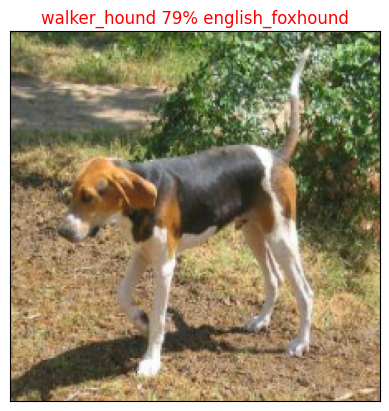

In [92]:
plot_pred(prediction_probabilites=predictions,labels=val_labels,images=val_images,n=42)

Now we've got one fucntion to visualise our fucntions predicitons, lets make another to view our models top 10 predictions

In [95]:
def plot_pred_conf(prediciton_probabilties, labels, n=1):
    """ 
    Plus the top 10 highest prediction confidences along with the truth label for sample n.
    """
    pred_prob, true_label = prediciton_probabilties[n], labels[n]

    pred_label = get_pred_label(pred_prob)

    top_10_pred_indexes =predictions[0].argsort()[-10:][::-1] 

    top_10_pred_values = pred_prob[top_10_pred_indexes]

    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color ="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),labels = top_10_pred_labels, rotation = "vertical")


    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass
                       






      

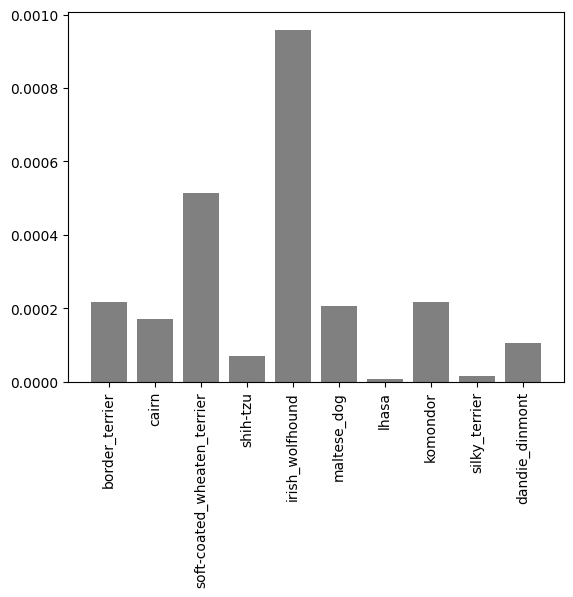

In [96]:
plot_pred_conf(prediciton_probabilties=predictions, labels= val_labels, n=9)

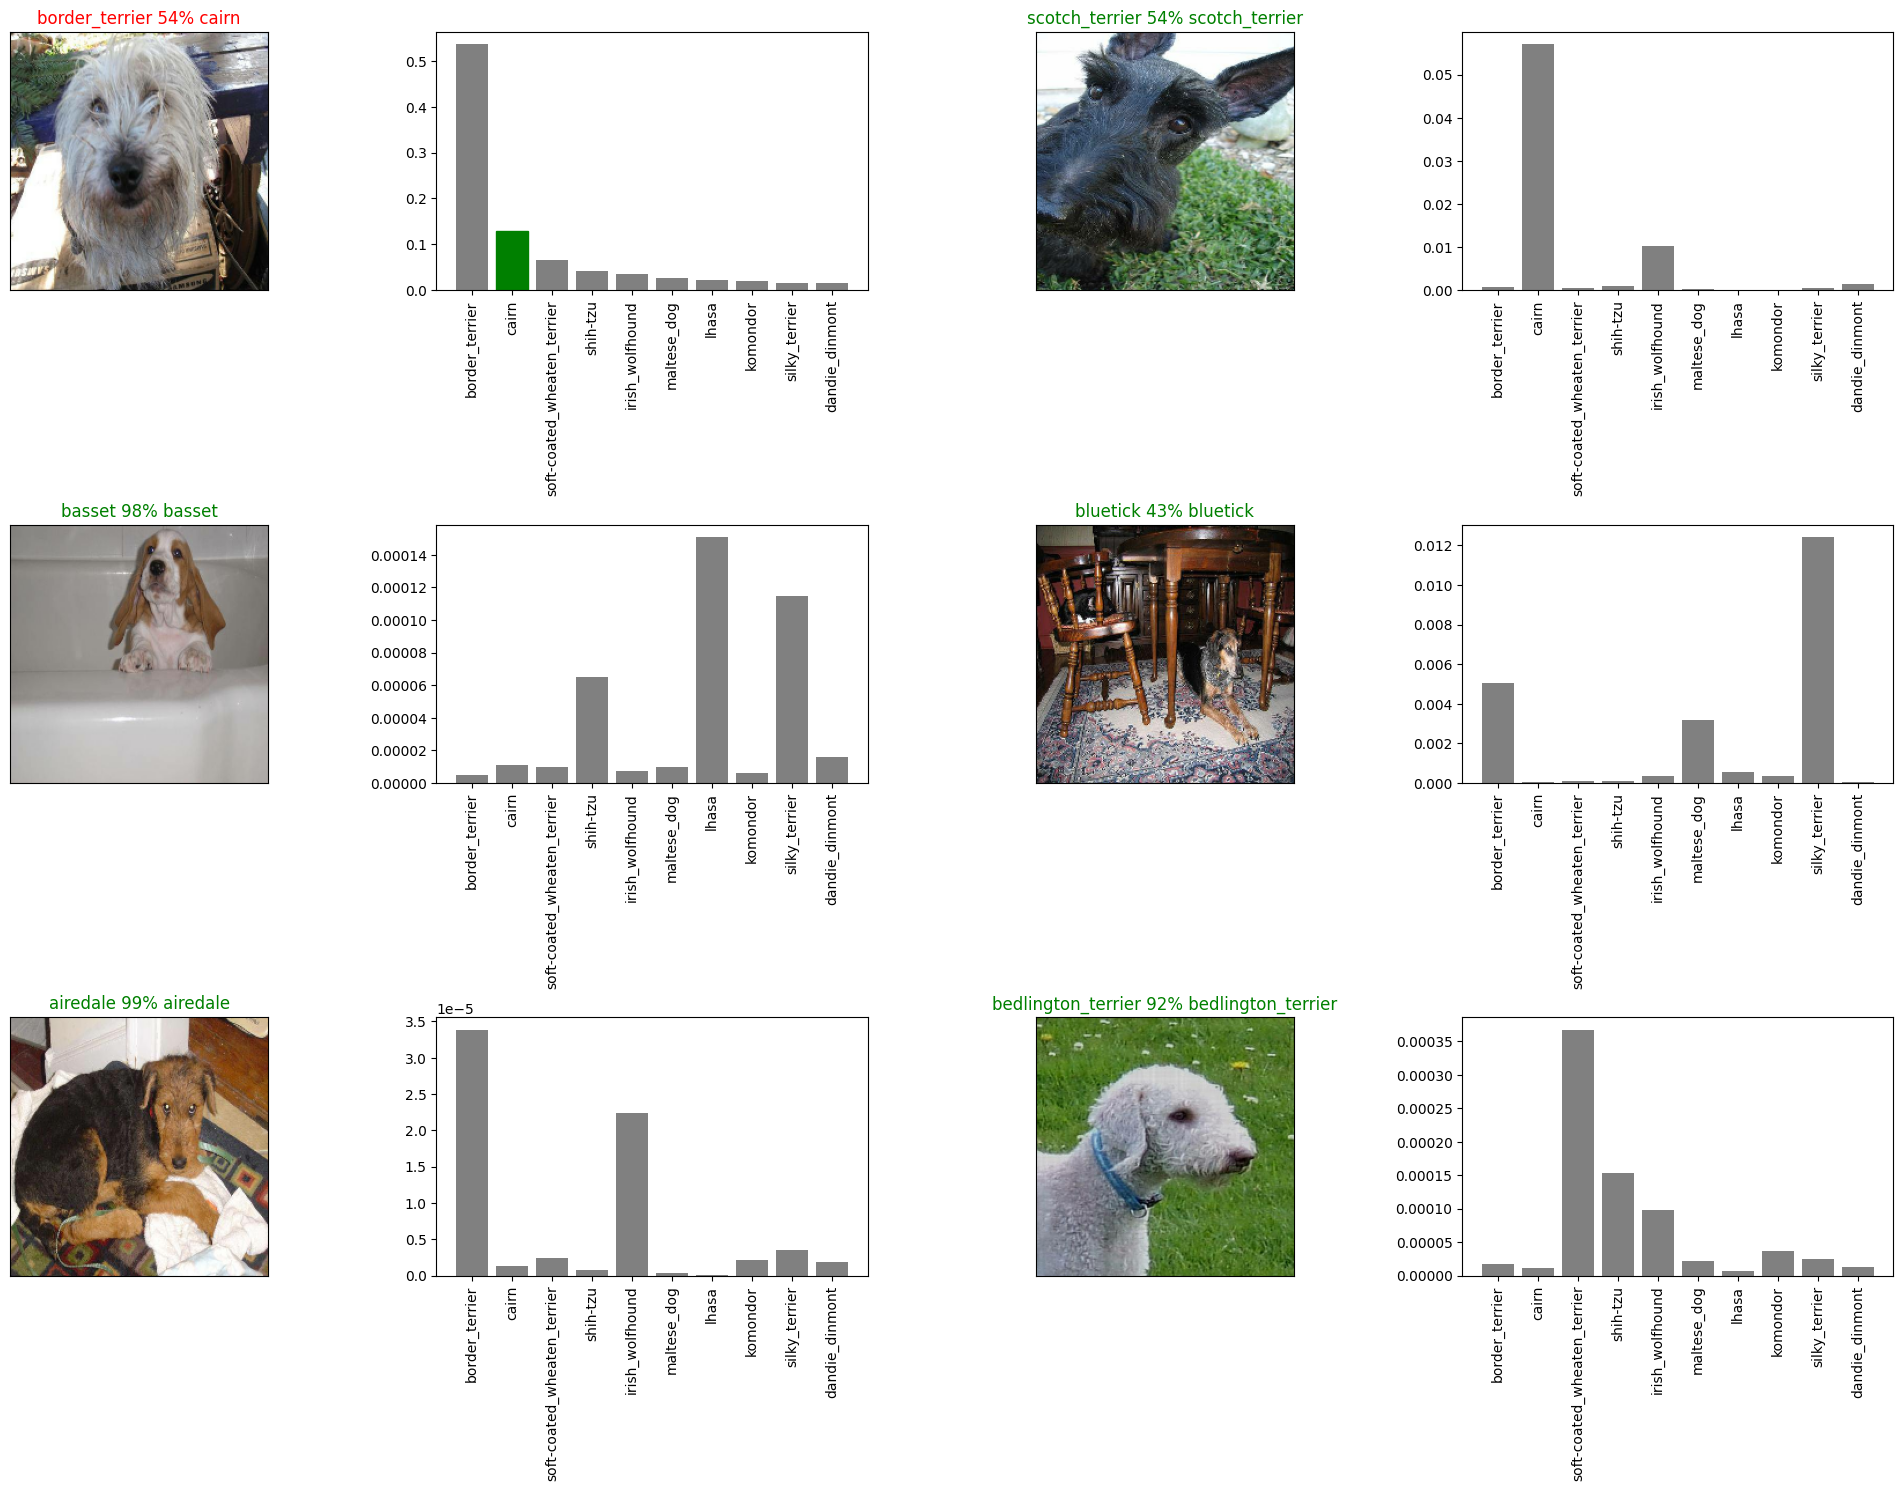

In [100]:
 # Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilites=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediciton_probabilties=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and Reloading the model

In [101]:
# create a function to save model
def save_model(model, suffix=None):
    
    """ 
    saves a model in amodels directory and append a suffix string
    """

    modeldir = os.path.join("/home/skywalker/Image-Classification-Model/models",datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

    model_path = modeldir + '-' + suffix + ".h5" # save format of model

    print("Saving model to :{model_path}...")
    model.save(model_path)
    return model_path


In [105]:
# Create a function to load a trained model
def load_model(model_path):
    """ 
    loads a saved model from a specified path.
    """
    print("Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})

    return model

In [106]:
# Save our model trained on 1000 images
# save_model(model, suffix = "1000-images-mobilenetv2-adam")


Saving model to :{model_path}...


'/home/skywalker/Image-Classification-Model/models/20240412-23371712945260-1000-images-mobilenetv2-adam.h5'

In [107]:
# Load model
loaded_model = load_model('/home/skywalker/Image-Classification-Model/models/20240412-23361712945171-1000-images-mobilenetv2-adam.h5')

Loading saved model from: {model_path}


## Training a big dog model (on Full data)

In [108]:
len(X), len(y)

(10222, 10222)

In [109]:
# create a data batch with full dataset

full_data = create_data_batches(X,y)

Creating training data batches...


In [111]:
# create a model for full model
full_model = create_model()


Building Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [112]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# no validation set when training on all the data, so w can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [114]:
# fit the model 
full_model.fit(x=full_data,epochs = NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100


320/320 [==============================] - 157s 491ms/step - loss: 0.1639 - accuracy: 0.9586
Epoch 2/100
320/320 [==============================] - 160s 500ms/step - loss: 0.1113 - accuracy: 0.9770
Epoch 3/100
237/320 [=====================>........] - ETA: 39s - loss: 0.0752 - accuracy: 0.9880

In [ ]:
# save full trained model
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")


In [ ]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "/home/skywalker/Image-Classification-Model/data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

In [ ]:
# How many test images are there?
len(test_filenames)

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Note: Since there are 10,000+ test images, making predictions could take a while, even on a GPU. So beware running the cell below may take up to an hour.

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = full_model.predict(test_data,
                                             verbose=1)

In [ ]:
# Check out the test predictions
test_predictions[:10]

# Preparing test dataset predicitons for kaggle

In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_path = "drive/My Drive/Data/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
preds_df.to_csv("drive/My Drive/Data/full_submission_1_mobilienetV2_adam.csv",
                 index=False)

# Maing predictions on custom images

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/Data/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

In [ ]:
# Make predictions on the custom data
custom_preds = full_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)